In [1]:
import gym
import pdb
from time import sleep
import pdb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from scipy import misc
from skimage import color
from collections import deque
import random
%matplotlib inline
print "Done"

/Users/thalles/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Done


In [2]:
PIXEL_DEPTH=255.
IMAGE_SIZE=84
def process_input(img):
    out = img[:171, :] # get only the playing area of the image
    out = misc.imresize(out, (IMAGE_SIZE,IMAGE_SIZE))
    r, g, b = out[:,:,0], out[:,:,1], out[:,:,2]
    out = r * (299./1000.) + r * (587./1000.) + b * (114./1000.)
    out = (out - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
    
    return out

In [3]:
GAME_NAME="MsPacman-v0"

[2016-10-05 22:33:55,266] Making new env: MsPacman-v0


Image origial shape: (210, 160, 3)
New image shape: (84, 84)


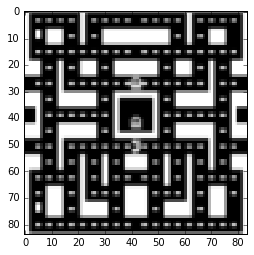

In [4]:
env = gym.make(GAME_NAME)
env.reset()

img = env.render('rgb_array')
print "Image origial shape:", img.shape
# plt.imshow(img, cmap='gray', interpolation='nearest')

out = process_input(img)
print "New image shape:", out.shape
plt.imshow(out.squeeze(), cmap='gray', interpolation='nearest')

In [5]:
NUM_ACTIONS = env.action_space.n
NUM_FRAMES_PER_STATE=4

In [6]:
SEED = 999

def weight_variable(name, shape):
  return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer(seed=SEED))

def weight_conv_variable(name, shape):
  return tf.get_variable(name=name, shape=shape, 
                         initializer=tf.contrib.layers.xavier_initializer_conv2d(seed=SEED))

def bias_variable(shape):
  initial = tf.zeros_initializer(shape=shape, dtype=tf.float32)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool(x, strides=[1, 2, 2, 1]):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=strides, padding='SAME')

In [7]:
CONV1_DEPTH=16
W_conv1 = weight_conv_variable("conv1", [8, 8, NUM_FRAMES_PER_STATE, CONV1_DEPTH])
b_conv1 = bias_variable([CONV1_DEPTH])

CONV2_DEPTH=32
W_conv2 = weight_conv_variable("conv2", [4, 4, CONV1_DEPTH, CONV2_DEPTH])
b_conv2 = bias_variable([CONV2_DEPTH])

FC1_SIZE = 255
W_fc1 = weight_variable("fc1", [11 * 11 * CONV2_DEPTH, FC1_SIZE])
b_fc1 = bias_variable([FC1_SIZE])

out_layer = weight_variable("out1", [FC1_SIZE, NUM_ACTIONS])
bias_layer = bias_variable([NUM_ACTIONS])

In [8]:
def model(inputs):
    # convolves 16 8×8 filters with stride 4
    h_conv1 = tf.nn.relu(conv2d(inputs, W_conv1) + b_conv1)
    h_pool1 = max_pool(h_conv1, strides=[1, 4, 4, 1])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool(h_conv2, strides=[1, 2, 2, 1])

    shape = h_pool2.get_shape().as_list()
    h_pool_flat = tf.reshape(h_pool2, [-1, shape[1] * shape[2] * shape[3]])

    # First fully connected layer
    h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)
    q_actions = tf.matmul(h_fc1, out_layer) + bias_layer

    return q_actions

In [9]:
def print_state(state):
    assert state.shape == (IMAGE_SIZE, IMAGE_SIZE, 4)
    f, axarr = plt.subplots(1, 4, figsize=(14,14))
    for i in range(4):
        img = state[:,:,i]
        axarr[i].imshow(img, cmap=plt.cm.Greys);
        axarr[i].set_title('Image: ' + str(i))
    plt.show()

In [34]:
class LearningAgent:
    def __init__(self, env, is_training=True):
        # game variables and constants
        self._env = env
        self.state = None
        self.ACTION_NAMES = self._env.get_action_meanings()
        self.NUM_ACTIONS = env.action_space.n
        self.action = 0 # default first action
        self.total_reward = 0
        self.rewards_per_game = []
        self.is_training = is_training
        
        # AI variables and constants
        self.REPLAY_MEN = 10000 # The paper remember the 1.000.000 most recent frames
        self.exp_replay_list = deque(maxlen=self.REPLAY_MEN)
        self.SKIP_FRAME_RATE = 4
        self.NUM_FRAMES_PER_STATE = 4
        self.OBSERVATION_STEPS = 500 # Papers value: 50000
        
        # Q LEARNING variables and constants
        self.INITIAL_EXPLORATION_PROB = 1.0 # Exploration probability
        self.FINAL_EXPLORATION_PROB = 0.1
        self.learning_rate = 0.00025 # lr from the paper 0.00025
        self.discount_factor = 0.99 # dicount factor from the paper 0.99
        self.MINI_BATCH_SIZE = 35 # minibatch size from the paper 35
        
        # Tensorflow variables
        self._session = tf.Session() 
        self._input = tf.placeholder(tf.float32, shape=(None,) + (IMAGE_SIZE,IMAGE_SIZE,self.NUM_FRAMES_PER_STATE), name="input_images")
        self._target = tf.placeholder(tf.float32, [None], name="input_targets")
        self._action = tf.placeholder(tf.float32, [None, self.NUM_ACTIONS], name="input_actions")
        
        # Create Deep model
        self.model_output = model(self._input)
        
        # train variables
        readout_action = tf.reduce_sum(tf.mul(self.model_output, self._action), reduction_indices=1)
        self.loss = tf.reduce_mean(tf.square(self._target - readout_action))
        self.train_operation = tf.train.RMSPropOptimizer(self.learning_rate, momentum=0.95, epsilon=0.01).minimize(self.loss)
        
        self._session.run(tf.initialize_all_variables())
    
    def to_one_hot_vec(self, actions):
        one_hot = np.zeros((self.MINI_BATCH_SIZE, self.NUM_ACTIONS))
        one_hot[np.arange(self.MINI_BATCH_SIZE), actions] = 1
        return one_hot

    def train(self):
        # Sample random minibatch of transitions (s_i, a_i, r_i, s_i+1)
        # from the experience replay list
        mini_batch = random.sample(self.exp_replay_list, self.MINI_BATCH_SIZE)
        previous_states = [d[0] for d in mini_batch]
        actions = [d[1] for d in mini_batch]
        rewards = [d[2] for d in mini_batch]
        current_states = [d[3] for d in mini_batch]
        
        # clip rewards between -1 and 1
        rewards = np.clip(rewards, a_min=0, a_max=1)
        
        agents_expected_reward = []
        # this gives us the agents expected reward for each action we might take
        agents_reward_per_action = self._session.run(self.model_output, feed_dict={self._input: current_states})
        
        for i in range(len(mini_batch)):
            if mini_batch[i][4]:
                # this was a terminal frame so there is no future reward...
                agents_expected_reward.append(rewards[i])
            else:
                # compute r_j + γ max Q(s_j, a; θ), 
                #    where:
                #      s_j is the current state
                #      θ are the CNNs learned weights
                agents_expected_reward.append(
                    rewards[i] + self.discount_factor * np.max(agents_reward_per_action[i]))
        
        print agents_expected_reward.shape
        print agents_expected_reward
        
        # Perform a gradient descent step on (y_j − Q(φ_j, a_j; θ))^2
        _, loss = self._session.run([self.train_operation, self.loss], feed_dict={
            self._input: previous_states,
            self._action: self.to_one_hot_vec(actions),
            self._target: agents_expected_reward})
        
        return loss
        
    def reset_env(self):
        self.rewards_per_game.append(self.total_reward)
        self.total_reward = 0
        return self._env.reset()

    def get_random_action(self):
        return self._env.action_space.sample()

    def get_action_name(self, action):
        return self.ACTION_NAMES[action]
    
    # for the first step, the state is the same state repeated [STATE_FRAMES] times
    def game_initial_setup(self):
        observations = process_input(self.reset_env())
        self.state = np.stack(tuple(observations for _ in range(self.NUM_FRAMES_PER_STATE)), axis=2)
        print "First state:", self.state.shape
        
    
    def get_next_action(self, step):
        # With probability p select a random action (a) otherwise select a = maxaQ∗(φ(st), a; θ)
        p = self.get_exploration_probability(step)
        
        if step % 70 == 0:
            print "Epsilon:", p

        if random.random() < p:
            out = self.get_random_action()
        else:
            current_state = np.expand_dims(self.state, axis=0)
            q_action = self._session.run(self.model_output, feed_dict={self._input: current_state})
            out = np.argmax(q_action)
        return out
    
    # perform a linear decay operation
    def get_exploration_probability(self, global_step):
        return (self.FINAL_EXPLORATION_PROB + 
                max(0, (self.INITIAL_EXPLORATION_PROB - self.FINAL_EXPLORATION_PROB) * 
                    (self.REPLAY_MEN - max(0, global_step - self.OBSERVATION_STEPS)) / self.REPLAY_MEN))
    
    def update(self, step):
        new_observation, reward, done, info = None, None, None, None
        self._env.render()
        
        if step % self.SKIP_FRAME_RATE == 0:    
            self.action = self.get_next_action(step)

        # Execute action a_t in emulator and observe reward r_t and image x_t+1
        new_observation, reward, done, info = self._env.step(self.action)
        self.total_reward += reward

        # Set s_t+1 = s_t, a_t, x_t+1 and preprocess s_t+1 = φ(st+1)
        new_observation = process_input(new_observation)
        new_observation = np.expand_dims(new_observation, axis=2)

        # store transition (φ_t, a_t, r_t, φ_t+1) in D (experience decay collection)
        new_state = np.append(self.state[:, :, 1:], new_observation, axis=2)
        self.exp_replay_list.append([self.state, self.action, reward, new_state, done])

        # only train if done observing
        if len(self.exp_replay_list) > self.OBSERVATION_STEPS and self.is_training:
            # Perform a gradient descent step on (y_j −Q(φ_j, a_j; θ))^2 
            loss = self.train()

            if step % 70 == 0:
                print "Step: ", step, "Action:", self.get_action_name(self.action), "Loss:", loss

            #print_state(self.exp_replay_list[self.count][0])
            #print"----------------------"
            #print_state(self.exp_replay_list[self.count][3])  
            #self.count += 1

        self.state = new_state
        
        if done:
            self.reset_env()
            return done

In [35]:
agent = LearningAgent(env)
agent.game_initial_setup()

First state: (84, 84, 4)


In [36]:
# Add ops to save and restore all the variables.
#saver = tf.train.Saver()
#save_path = saver.save(agent._session, "./model/model.ckpt")

In [37]:
DELAY = 0.05
TOTAL_TRAIN_STEPS = 100000 # article trained with 10.000.000 million steps

for step in range(TOTAL_TRAIN_STEPS):
    
    done = agent.update(step)

    # sleep(DELAY)

    if done:
        print("Episode finished after {} timesteps".format(step))

Epsilon: 1.0
Epsilon: 1.0
Epsilon: 1.0
Epsilon: 1.0
Episode finished after 434 timesteps


AttributeError: 'list' object has no attribute 'shape'

In [29]:
DELAY = 0.05
TOTAL_TEST_STEPS = 100000 # article trained with 10.000.000 million steps
agent.is_training = False
# agent.INITIAL_EXPLORATION_PROB = 0.05
for step in range(TOTAL_TEST_STEPS):
    
    done = agent.update(step)

    # sleep(DELAY)

    if done:
        print("Episode finished after {} timesteps".format(step))

Epsilon: 0.1
Episode finished after 66 timesteps
Epsilon: 0.1
Epsilon: 0.1
Epsilon: 0.1
Episode finished after 534 timesteps
Epsilon: 0.1
Epsilon: 0.1
Epsilon: 0.1
Episode finished after 972 timesteps
Epsilon: 0.1
Epsilon: 0.1
Epsilon: 0.1
Epsilon: 0.1
Episode finished after 1407 timesteps
Epsilon: 0.1
Epsilon: 0.1
Epsilon: 0.1


KeyboardInterrupt: 

In [ ]:
img = agent.exp_replay_list[0][3]
print img.shape
#print agent.state[:, :, 1].shape
plt.imshow(img[:,:,3], cmap='gray', interpolation='nearest')